In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


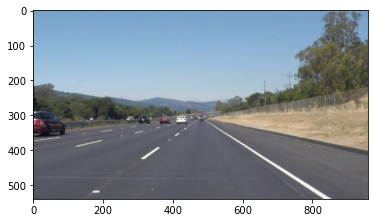

In [3]:
image = mpimg.imread('data/test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function to use as a starting point to 
    average/extrapolate the line segments we detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Need to think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If we want to make the lines semi-transparent, we can think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Detection on Images

In [6]:
import os
os.listdir("data/test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

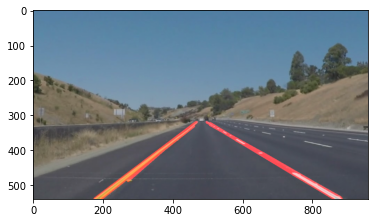

In [8]:
img = mpimg.imread('data/test_images/whiteCarLaneSwitch.jpg')

gray = grayscale(img)
kernel_size = 5
low_threshold = 50
high_threshold = 150
edges = canny(gaussian_blur(gray, kernel_size), low_threshold, high_threshold)
# plt.imshow(edges, cmap='Greys_r')

# This time we are defining a four sided polygon to mask
imshape = img.shape
vertices = np.array([[(0,imshape[0]),(440, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)

masked_edges = region_of_interest(edges, vertices)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2
theta = np.pi/180
threshold = 40
min_line_len = 100
max_line_gap = 130
#line_image = np.copy(img)*0 #creating a blank to draw lines on

line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
# plt.imshow(line_img)

combo = weighted_img(line_img, img, α=0.8, β=1., λ=0.)
plt.imshow(combo)

### Detection on Videos

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(img):
    gray = grayscale(img)
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150
    edges = canny(gaussian_blur(gray, kernel_size), low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(440, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = np.pi/180
    threshold = 40
    min_line_len = 100
    max_line_gap = 130
    #line_image = np.copy(img)*0 #creating a blank to draw lines on

    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    result = weighted_img(line_img, img, α=0.8, β=1., λ=0.)
    return result

In [14]:
os.listdir("data/test_videos/")

['solidWhiteRight.mp4']

In [15]:
white_output = 'white.mp4'
clip1 = VideoFileClip("data/test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

t:   5%|▍         | 10/221 [00:00<00:02, 98.62it/s, now=None]

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
Wall time: 1.88 s


# Fin.